In [5]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import skops.io as sio
import gc

O dataset é constituído por imagens de dimensões 32 x 32 x 3 com os 3 canais RGB

In [6]:
def load(arr, path):
    for filename in os.listdir(path):
        arr.append(np.reshape(cv2.imread(os.path.join(path, filename)), (3072,)))

In [7]:
if not os.path.exists("test.txt"):
    test_x = []
    load(test_x, "test/FAKE/")
    load(test_x, "test/REAL/")
    train_x = []
    load(train_x, "train/FAKE/")
    load(train_x, "train/REAL/")
    # Os dados são salvos como arquivo binário para acelerar a leitura dos dados
    # na próxima leitura
    np.array(test_x, dtype=np.uint8).tofile("test.txt")
    np.array(train_x, dtype=np.uint8).tofile("train.txt")

Os dados são números inteiros de 0 a 255 representando o valor de cada pixel, para normalizar os dados precisamos apenas dividir todos os valores por 255

In [8]:
test_x = np.fromfile("test.txt", dtype=np.uint8).reshape((20000, 32, 32, 3)) / 255
train_x = np.fromfile("train.txt", dtype=np.uint8).reshape((100000,32, 32,3)) / 255
print(test_x.shape, train_x.shape)

(20000, 32, 32, 3) (100000, 32, 32, 3)


Os dados estão distribuídos de forma que a primeira metade dos dados faz parte da classe falsa e a segunda metade da classe real. Os vetores y são preenchidos com 0s e 1s de acordo com as classes

In [9]:
test_y = np.append(np.zeros((10000,)), np.ones((10000,)))
train_y = np.append(np.zeros((50000,)), np.ones((50000,)))
print(test_y.shape, train_y.shape)

(20000,) (100000,)


As imagens que compõem o dataset são imagens de aviões, automóveis, pássaros, cervos, gatos, cachorros, sapos, cavalos, navios e caminhões. Todas as imagens tem características diferentes não seguindo padrões aparentes

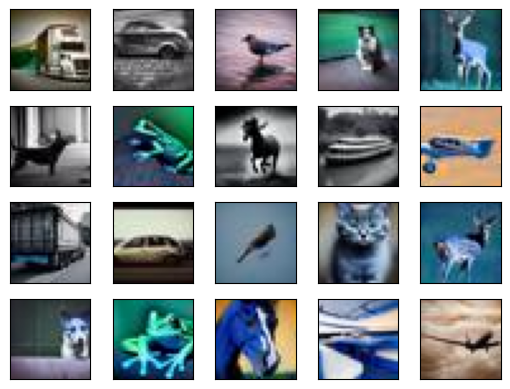

In [10]:
for i in range(1,21):
    plt.subplot(4, 5, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_x[i-1])

In [11]:
def shuffled_data(data_x, data_y):
    temp = list(zip(data_x, data_y))
    random.shuffle(temp)
    a, b = zip(*temp)
    return (np.array(a), np.array(b))
    

In [12]:
def auxiliar_data(data_x:np.ndarray, data_y, size):
    half = int(len(data_x) / 2)
    fake_x, fake_y = shuffled_data(range(half), range(half))
    real_x, real_y = shuffled_data(range(half,len(data_y)), range(half,len(data_y)))
    x = np.append(data_x[fake_x[:int(size/2)]], data_x[real_x[:int(size/2)]], 0)
    y = np.append(data_y[fake_y[:int(size/2)]], data_y[real_y[:int(size/2)]], 0)
    return (x,y)


In [13]:
flat_train_x = train_x.reshape(len(train_x), 3072)
flat_test_x = test_x.reshape(len(test_x), 3072)

In [14]:
aux_test_x, aux_test_y = auxiliar_data(flat_test_x, test_y, 400)
aux_train_x, aux_train_y = auxiliar_data(flat_train_x, train_y, 2000)


In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

A primeira solução para resolver o problema vai ser o modelo de K-vizinhos mais próximos. O primeiro passo é decidir os hiper parâmetros do modelo, para isso vamos testar os valores do parâmetro k de 1 a 20 e comparar os resultados obtidos com cada valor de k

In [16]:
knn_scores = []
confusion_matrices = []

if os.path.exists("knn_scores.npy"):
    with open('knn_scores.npy', 'rb') as f:
        knn_scores = np.load(f, allow_pickle=True)
else:
    iterations = 30
    a = [auxiliar_data(flat_test_x, test_y, 400) for i in range(iterations)]
    b = [auxiliar_data(flat_train_x, train_y, 2000) for i in range(iterations)]
    for i in range(1, 20):
        mean = []
        confusion_matrix_list = []
        for k in range(iterations):
            knn_model = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
            knn_model.fit(b[k][0], b[k][1])
            mean.append(knn_model.score(a[k][0], a[k][1]))
            
            # Criação da matriz de confusão
            predictions = knn_model.predict(a[k][0])
            confusion_matrix_list.append(confusion_matrix(a[k][1], predictions))
        
        knn_scores.append(mean)
        confusion_matrices.append(confusion_matrix_list)

Para cada valor de k testamos a precisão do modelo 30 vezes randomizando os dados, após obtermos os resultados podemos plotar um gráfica para mostrar a relação dos valores

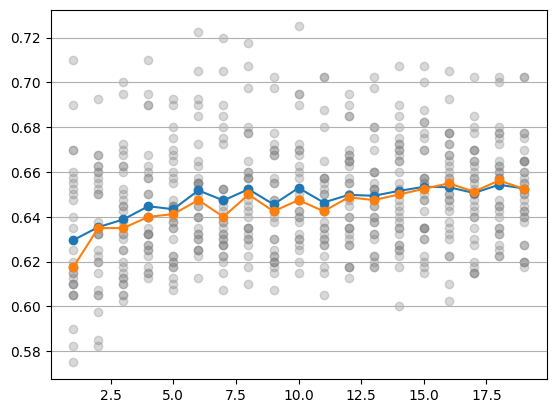

In [17]:
plt.plot(range(1, 20), [np.mean(x) for x in knn_scores], '-o')
plt.plot(range(1, 20), [np.median(x) for x in knn_scores], '-o')
points_x = [np.full((len(knn_scores[0]),), i) for i in range(1, 20)]
for x, y in zip(points_x, knn_scores):
    plt.scatter(x, y, color='gray', alpha=0.3)
plt.grid(axis='y')

Apesar dos resultados variarem bastante ao plotarmos a media e a mediana das 30 iterações o gráfico forma algo parecido com uma curva crescente achatada e é o bastante para determinar o valor de k com o melhor resultado

In [18]:
if not os.path.exists('knn_scores.npy'):
    with open('knn_scores.npy', 'wb') as f:
        np.save(f, np.array(knn_scores,dtype=object), allow_pickle=True)

In [19]:
if not os.path.exists('confusion_matrices.npy'):
    with open('confusion_matrices.npy', 'wb') as f:
        np.save(f, np.array(confusion_matrices,dtype=object), allow_pickle=True) 

In [20]:
if os.path.exists('confusion_matrices.npy'):
    with open('confusion_matrices.npy', 'rb') as f:
        confusion_matrices = np.load(f, allow_pickle=True)

In [118]:
with open('knn_pred.txt', 'rb') as f:
        knn_pred = np.fromfile(f)

Curva ROC para knn

In [21]:
n = range(1, 20)[np.argmax([np.mean(x) for x in knn_scores])]

com o valor de k que obteve o melhor resultado vamos treinar o modelo com o resto dos dados

In [22]:
with open('final_knn_score.npy', 'rb') as f:
    final_knn_score = np.load(f, allow_pickle=True).flatten()[0]

In [122]:
if os.path.exists("final_knn_score.npy"):
    knn_model = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)
    knn_model.fit(flat_train_x, train_y)
    knn_proba = knn_model.predict_proba(flat_test_x)
    final_knn_score = knn_model.score(flat_test_x, test_y)
final_knn_score


In [128]:
sio.dump(sio.dumps(knn_proba), 'knn_proba')

O modelo knn funciona de forma simples, ele agrupa os valores de acordo com as suas proximidade e faz predições calculando a proximidade do valor de entrada com os grupos, assim o sucesso do modelo depende da previsibilidade dos dados já que valores afastados dos grupos com suas classes correspondentes não teriam o resultado correto

Como falado anteriormente as imagens do dataset não seguem padrão específico e portando os valores dos pixels nas imagens não são próximos uns dos outros o bastante para obtermos a melhor precisão, no entanto ainda conseguimos chegar em um score perto de 70%

In [24]:
if not os.path.exists('final_knn_score.npy'):
    with open('final_knn_score.npy', 'wb') as f:
        np.save(f, np.array(final_knn_score,dtype=object), allow_pickle=True)

O próximo modelo a ser usado é o de Árvore de decisão

In [25]:
from sklearn.tree import DecisionTreeClassifier
import itertools as it

Para a definição dos parâmetros do modelo de árvore usaremos a mesma estratégia usada no modelo knn

In [27]:
tree_scores = []
confusion_matrices_tree = []
criterions = ["gini", "entropy", "log_loss"]
max_depths = range(2, 9, 2)
if not os.path.exists("tree_scores.npy"):
    iterations = 1
    a = [auxiliar_data(flat_test_x, test_y, 4000) for _ in range(iterations)]
    b = [auxiliar_data(flat_train_x, train_y, 20000) for _ in range(iterations)]
    for comb in it.product(criterions, max_depths):
        mean = []
        confusion_matrix_tree_list = []
        for k in range(iterations):
            tree_model = DecisionTreeClassifier(criterion=comb[0], max_depth=comb[1])
            tree_model.fit(b[k][0], b[k][1])
            mean.append(tree_model.score(a[k][0], a[k][1]))
            predictions = tree_model.predict(a[k][0])
            confusion_matrix_tree_list.append(confusion_matrix(a[k][1], predictions))
        tree_scores.append(mean)
        confusion_matrices_tree.append(confusion_matrix_tree_list)

In [28]:
if not os.path.exists('tree_scores.npy'):
    with open('tree_scores.npy', 'wb') as f:
        np.save(f, np.array(tree_scores,dtype=object), allow_pickle=True)

In [132]:
with open('tree_scores.npy', 'rb') as f:
    tree_scores = np.load(f, allow_pickle=True)

In [30]:
if not os.path.exists('confusion_matrices_tree1.npy'):
    with open('confusion_matrices_tree1.npy', 'wb') as f:
        np.save(f, np.array(confusion_matrices_tree,dtype=object), allow_pickle=True)

In [31]:
with open('confusion_matrices_tree.npy', 'rb') as f:
    confusion_matrices_tree:list = np.load(f, allow_pickle=True)

In [34]:
tree_scores_avg = [np.mean(x) for x in tree_scores]

In [35]:
combs = list(it.product(criterions, max_depths))

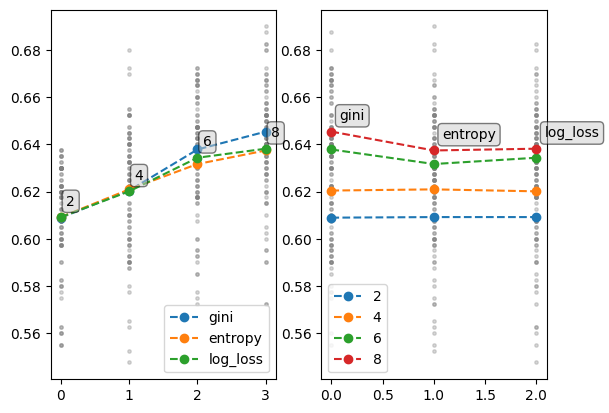

In [36]:
relation_matrix = np.array(combs, dtype=tuple).reshape((len(criterions),len(max_depths), 2))

for matrix, i, param in zip([relation_matrix, relation_matrix.transpose((1,0,2))], range(1, 3), [max_depths, criterions]):
    plt.subplot(1, 2, i)
    indexes = None
    for p in matrix:
        indexes = np.where([np.array([(y[0],y[1]) == (x[0],x[1]) for x in p]).any() for y in combs])[0]
        
        plt.plot(range(len(p)), [tree_scores_avg[i] for i in indexes], '--o', label=p[0][1-i])
        plt.legend()

        points_x = [np.full((len(tree_scores[0]),), i) for i in range(len(p))]
        points_y = [tree_scores[i] for i in indexes]

        plt.scatter(points_x, points_y, color='gray', alpha=0.3, s=6)
    for x, y in zip(range(len(indexes)),[tree_scores_avg[i] for i in indexes]):
        plt.annotate(str(param[x]), (x+0.08, y+0.005), bbox={'boxstyle':"round", 'fc':"0.8", 'alpha': 0.5})


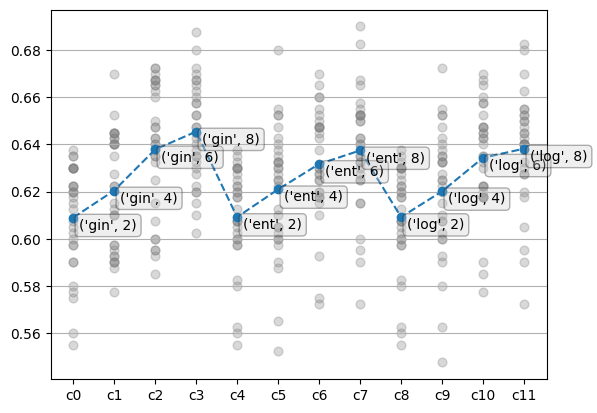

In [37]:
plt.plot([f'c{i}' for i in range(len(tree_scores))],  tree_scores_avg, '--o')
points_x = [np.full((len(tree_scores[0]),),i)for i in range(len(tree_scores))]
for x, y in zip(points_x, tree_scores):
    plt.scatter(x, y, color='gray', alpha=0.3, s=40)
plt.grid(axis='y')

labels = [str((x[0][:3], x[1])) for x in combs]

for x, y in zip(range(len(tree_scores_avg)), tree_scores_avg):
    plt.annotate(str(labels[x]), (x+0.15, y-0.005),
                 bbox={'boxstyle': "round", 'fc': "0.8", 'alpha': 0.3})
None

In [38]:
comb = list(it.product(criterions, max_depths))[np.argmax(tree_scores_avg)]

In [169]:
tree_model = sio.loads(sio.load("tree_model.skops", trusted=True), trusted=True)

In [170]:
if not os.path.exists('tree_model.skops'):
    tree_model = DecisionTreeClassifier(criterion=comb[0], max_depth=comb[1])
    tree_model.fit(flat_train_x, train_y)
tree_model.score(flat_test_x, test_y)

0.6989

In [172]:
tree_proba = tree_model.predict_proba(flat_test_x)

In [171]:
if not os.path.exists('tree_model.skops'):
    obj = sio.dumps(tree_model)
    sio.dump(obj, "tree_model.skops")


In [42]:
import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, PReLU, ReLU, LeakyReLU
from keras.models import Sequential, load_model
from keras.optimizers import Adamax
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import TopKCategoricalAccuracy

In [43]:
layerCounts = [1,2,3,4]
ann_scores = []
iterations = 10
a = auxiliar_data(flat_test_x, test_y, 2000)
b = auxiliar_data(flat_train_x, train_y, 10000)
if not os.path.exists('ann_scores'):
    for layer in layerCounts: 
        for i in it.product([50], repeat=layer):
            mean = []
            for m in range(iterations):
                ann_model = Sequential()
                for k in i:
                    ann_model.add(Dense(k, activation="relu"))
                ann_model.add(Dense(2, "sigmoid"))
                ann_model.compile(optimizer=Adamax(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
                ann_model.fit(b[0],b[1],epochs=10, use_multiprocessing=True,verbose=False)
                mean.append(ann_model.evaluate(a[0], a[1], use_multiprocessing=True, verbose=False)[1])
            ann_scores.append(mean)
            print(ann_scores[-1])


In [44]:
ann_scores = sio.loads(sio.load("ann_scores", trusted=True), trusted=True)

In [45]:
if not os.path.exists('ann_scores'):
    sio.dump(sio.dumps(ann_scores), "ann_scores")

In [46]:
ann_scores_avg = [np.mean(i) for i in ann_scores]


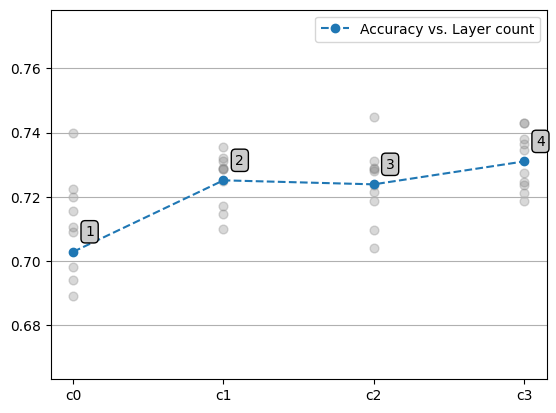

In [47]:
plt.plot([f'c{i}' for i in range(len(ann_scores))],
         ann_scores_avg, '--o', label='Accuracy vs. Layer count')
plt.legend()
points_x = [np.full((len(ann_scores[0]),),x) for x in range(len(ann_scores))]
for x, y in zip(points_x, ann_scores):
    plt.scatter(x, y, color='gray', alpha=0.3, s=40)
plt.grid(axis='y')
for x, y in zip(range(len(ann_scores_avg)), ann_scores_avg):
    plt.annotate(str(layerCounts[x]), (x+0.08, y+0.005), bbox={'boxstyle': "round", 'fc': "0.8"})
plt.ylim([np.mean(ann_scores_avg)*0.92, np.mean(ann_scores_avg)*1.08])
None

In [48]:
layerCount = layerCounts[np.argmax([np.mean(x) for x in ann_scores])]

In [49]:
ann_scores = []
iterations = 10
outputSizes = [list(it.repeat(x, layerCount)) for x in [32,64,128,256]]
outputSizes.append([32, 64, 128, 256])
outputSizes.append([256, 128, 64, 32])

if not os.path.exists('ann_scores1'):
    for i in outputSizes:
        mean = []
        for m in range(iterations):
            ann_model = Sequential()
            for k in i:
                ann_model.add(Dense(k, activation="relu"))
            ann_model.add(Dense(2, "sigmoid"))
            ann_model.compile(optimizer=Adamax(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
            ann_model.fit(b[0],b[1],epochs=10, use_multiprocessing=True,verbose=False)
            mean.append(ann_model.evaluate(a[0], a[1], use_multiprocessing=True, verbose=False)[1])
        ann_scores.append(mean)
        print(ann_scores[-1])


In [50]:
ann_scores = sio.loads(sio.load("ann_scores1", trusted=True), trusted=True)


In [51]:
if not os.path.exists('ann_scores1'):
    sio.dump(sio.dumps(ann_scores), "ann_scores1")

In [52]:
ann_scores_avg = [np.mean(x) for x in ann_scores]

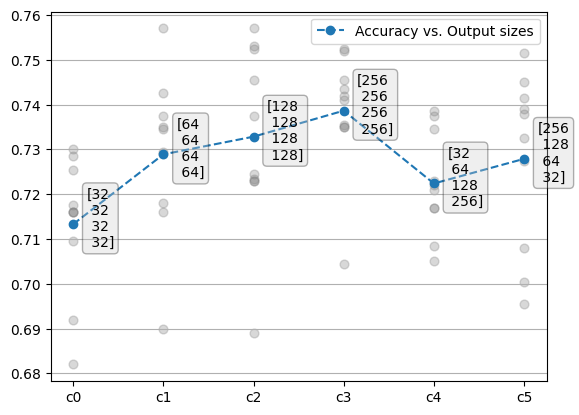

In [53]:
plt.plot([f'c{i}' for i in range(len(ann_scores))], ann_scores_avg, '--o', label='Accuracy vs. Output sizes')
plt.legend()
points_x = [np.full((len(ann_scores[0]),), x) for x in range(len(ann_scores))]
for x, y in zip(points_x, ann_scores):
    plt.scatter(x, y, color='gray', alpha=0.3, s=40)
plt.grid(axis='y')

for x, y in zip(range(len(ann_scores_avg)), ann_scores_avg):
    plt.annotate(str(outputSizes[x]).replace(',', '\n'), (x+0.15, y-0.005),
                 bbox={'boxstyle': "round", 'fc': "0.8", 'alpha': 0.3})


In [54]:
sizes = outputSizes[np.argmax([np.mean(x) for x in ann_scores])]

In [55]:
ann_scores = []
iterations = 100
activations = [ 'leaky1', 'relu', 'leaky2']

if not os.path.exists('ann_scores3'):
    for i in activations:
        mean = []
        for m in range(iterations):
            ann_model = Sequential()
            for size in sizes:
                ann_model.add(Dense(k))
                if i == "relu":
                    ann_model.add(ReLU())
                elif i == 'leaky':
                    ann_model.add(LeakyReLU(alpha=0.1))
                else:
                    ann_model.add(LeakyReLU(alpha=0.2))
            ann_model.add(Dense(2, "sigmoid"))
            ann_model.compile(
                optimizer=Adamax(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
            ann_model.fit(b[0], b[1], epochs=10,
                          use_multiprocessing=True, verbose=False)
            mean.append(ann_model.evaluate(
                a[0], a[1], use_multiprocessing=True, verbose=False)[1])
        ann_scores.append(mean)
        print(ann_scores[-1])


In [56]:
if not os.path.exists('ann_scores3'):
    sio.dump(sio.dumps(ann_scores), "ann_scores3")

In [57]:
ann_scores = sio.loads(sio.load("ann_scores3", trusted=True), trusted=True)

In [58]:
ann_scores_avg = [np.mean(x) for x in ann_scores]

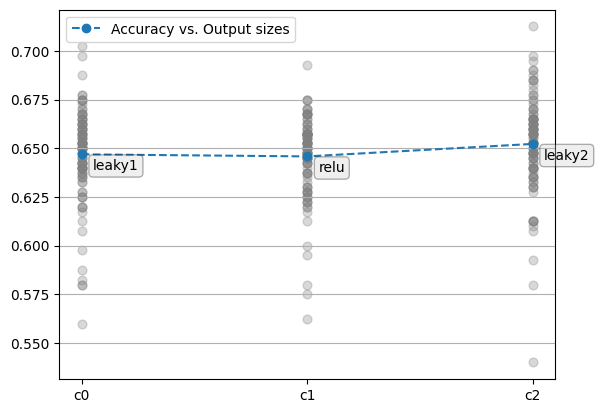

In [59]:
plt.plot([f'c{i}' for i in range(len(ann_scores))],
         [np.mean(x) for x in ann_scores], '--o', label='Accuracy vs. Output sizes')
plt.legend()
points_x = [np.full((len(ann_scores[0]),), x) for x in range(len(ann_scores))]
for x, y in zip(points_x, ann_scores):
    plt.scatter(x, y, color='gray', alpha=0.3, s=40)
plt.grid(axis='y')

for x, y in zip(range(len(ann_scores_avg)), ann_scores_avg):
    plt.annotate(str(activations[x]).replace(',', '\n'), (x+0.05, y-0.008),
                 bbox={'boxstyle': "round", 'fc': "0.8", 'alpha': 0.3})


In [60]:
ann_model = Sequential()

for size in sizes:
    ann_model.add(Dense(size))
    ann_model.add(LeakyReLU(alpha=0.1))
ann_model.add(Dense(2, activation="sigmoid"))

In [61]:
ann_model.compile(optimizer=Adamax(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

In [62]:
if os.path.exists('ann_model'):
    ann_model = load_model('ann_model')
else:
    ann_model.fit(flat_test_x, test_y, epochs=10, validation_split=0.2, use_multiprocessing=True)
    ann_model.save('ann_model')

Epoch 1/10
500/500 [==============================] - 23s 37ms/step - loss: 0.6182 - acc: 0.6464 - val_loss: 0.6438 - val_acc: 0.6538
Epoch 2/10
500/500 [==============================] - 16s 32ms/step - loss: 0.5522 - acc: 0.7073 - val_loss: 0.7478 - val_acc: 0.5253
Epoch 3/10
500/500 [==============================] - 12s 24ms/step - loss: 0.5203 - acc: 0.7331 - val_loss: 0.7754 - val_acc: 0.5602
Epoch 4/10
500/500 [==============================] - 11s 22ms/step - loss: 0.5048 - acc: 0.7487 - val_loss: 0.9602 - val_acc: 0.3943
Epoch 5/10
500/500 [==============================] - 11s 23ms/step - loss: 0.4905 - acc: 0.7542 - val_loss: 0.7365 - val_acc: 0.5645
Epoch 6/10
500/500 [==============================] - 12s 23ms/step - loss: 0.4722 - acc: 0.7679 - val_loss: 0.7339 - val_acc: 0.6300
Epoch 7/10
500/500 [==============================] - 12s 24ms/step - loss: 0.4641 - acc: 0.7741 - val_loss: 0.8659 - val_acc: 0.5075
Epoch 8/10
500/500 [==============================] - 12s 23ms

In [136]:
ann_model.evaluate(flat_test_x, test_y)

625/625 [==============================] - 6s 8ms/step - loss: 0.4604 - acc: 0.7775


[0.4604256749153137, 0.7775499820709229]

In [139]:
ann_proba = ann_model.predict(flat_test_x, use_multiprocessing=True)

625/625 [==============================] - 6s 10ms/step


In [64]:
def normalize_matrix(matrix):
    mn, mx = matrix.min(), matrix.max()
    if(mn < 0):
        mn *= -1
    else:
        mn = 0
    return (matrix+mn)/(mx+mn)


In [65]:
weights, bias = ann_model.layers[0].get_weights()

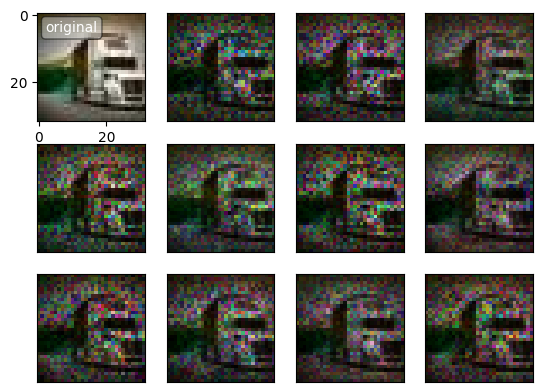

In [66]:
plt.subplot(3, 4, 1)
plt.imshow(test_x[0])
plt.annotate("original",[2,5], color='w', bbox={'boxstyle': 'round', 'fc': '0.8', 'alpha': 0.5})
for i in range(2, 13):
    processed_img = weights[:, i-2].reshape(32, 32, 3)
    processed_img = normalize_matrix(processed_img)
    processed_img = np.multiply(processed_img, test_x[0])
    plt.subplot(3,4,i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(processed_img)


In [67]:
processed_img = Sequential(layers=ann_model.layers[:2]).predict(flat_test_x[:1])
processed_img = normalize_matrix(processed_img.reshape((16, 16)))


1/1 [==============================] - 0s 391ms/step


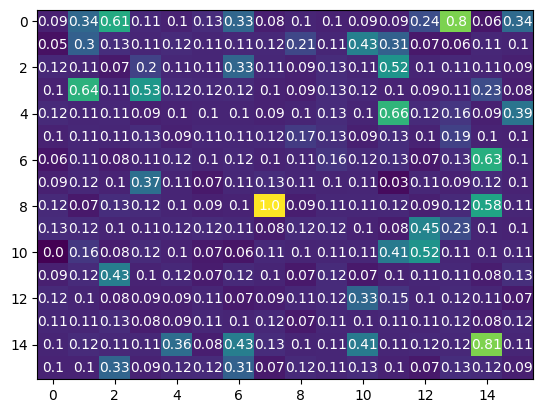

In [68]:
plt.imshow(processed_img, interpolation='nearest', aspect='auto')

for x in range(len(processed_img)):
    for y in range(len(processed_img[x])):
            plt.text(y,x, round(processed_img[x][y], 2), ha="center",va='center', color="w")

In [69]:
cnn_model = Sequential()

cnn_model.add(Conv2D(128, 3, input_shape=(32,32,3)))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPool2D())
cnn_model.add(Conv2D(128, 3))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPool2D())

cnn_model.add(Flatten())
cnn_model.add(Dense(256))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(Dense(256))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(Dense(256))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(Dense(256))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(Dense(2, activation="sigmoid"))

In [70]:
cnn_model.compile(optimizer=Adamax(), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [109]:
if os.path.exists('cnn_model'):
    cnn_model = load_model('cnn_model')
else:
    cnn_model.fit(train_x, train_y, epochs=3, use_multiprocessing=True, batch_size=64)
    cnn_model.save("cnn_model")


In [110]:
cnn_model.evaluate(test_x, test_y, use_multiprocessing=True)

625/625 [==============================] - 56s 87ms/step - loss: 0.1648 - accuracy: 0.9360


[0.16478051245212555, 0.9360499978065491]

In [111]:
filters, bias = cnn_model.layers[0].get_weights()

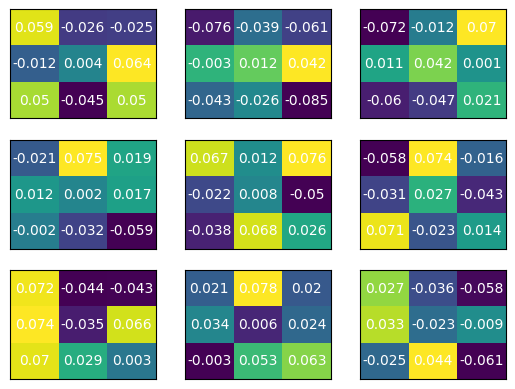

In [112]:
for i in range(1,10):
    plt.subplot(3,3,i)
    f = filters[:,:,0,i-1]
    plt.xticks([])
    plt.yticks([])
    plt.imshow(f, aspect='auto', interpolation='nearest')

    for x in range(len(f)):
        for y in range(len(f[x])):
            text = plt.text(y,x, round(f[x][y], 3),
                   ha="center",va='center', color="w")


In [113]:
feature_maps = Sequential(layers=cnn_model.layers[:1]).predict(test_x[2:3])

1/1 [==============================] - 0s 120ms/step


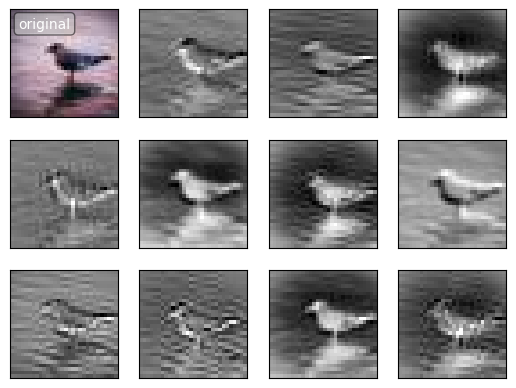

In [114]:
plt.subplot(3,4,1)
plt.xticks([])
plt.yticks([])
plt.imshow(test_x[2])
plt.annotate("original",[2,5], color='w', bbox={'boxstyle': 'round', 'fc': '0.8', 'alpha': 0.5})

for i in range(2,13):
    plt.subplot(3,4,i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(feature_maps[0][:,:,i+11], cmap='gray')

In [141]:
from sklearn.metrics import roc_auc_score, roc_curve

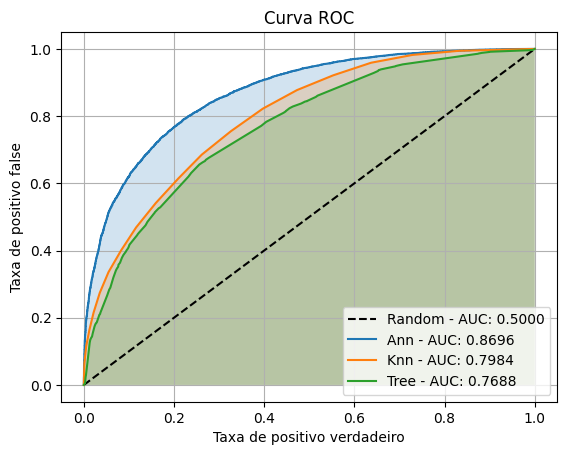

In [192]:
plt.plot([0,1], [0,1], '--', color='black', label='Random - AUC: 0.5000')
for proba, name in zip([ann_proba,knn_proba, tree_proba, ], ['Ann','Knn', 'Tree' ]):
    fpr, tpr, _ = roc_curve(test_y, proba.transpose()[0])
    auc = str(round(1 - roc_auc_score(test_y, proba.transpose()[0]), 4)).ljust(6, '0')
    plt.fill([*tpr, tpr[-1]], [*fpr, 0], alpha=0.2)
    plt.plot(tpr, fpr, label=f'{name} - AUC: {auc}')
    plt.legend(loc='lower right')
plt.xlabel('Taxa de positivo verdadeiro')
plt.ylabel('Taxa de positivo false')
plt.title('Curva ROC')
plt.grid()
